#### INFO

In [1]:
### Imports ###

include("../src/QComp.jl")
using .QComp

using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers
using Kronecker

#### Graph learning functions

In [2]:
abstract type AbstractGraph end

mutable struct Graph{T<:Vector{Vector{TT}} where TT<:Integer} <: AbstractGraph
    l::T
    Graph(l) = new{typeof(l)}(sort_lexicographic(l))
end

mutable struct SignedGraph{T<:Vector{Vector{T}} where T<:Integer, TT<:Vector{TT} where TT<:Integer} <: AbstractGraph
    l::T
    s::TT
    SignedGraph(l, s) = new{typeof(l), typeof(s)}(sort_lexicographic(l, s)...)
end

function sort_lexicographic(vec::Vector{Vector{Int}})
    return unique(sort(sort([sort(sub_vec) for sub_vec in vec]), by=length))
end

function sort_lexicographic(vec_l::Vector{Vector{Int}}, vec_s::Vector{Int})
    res_l = sort(sort([sort(sub_vec) for sub_vec in vec_l]), by=length)
    perm = indexin(res_l, [sort(sub_vec) for sub_vec in vec_l])
    res_s = vec_s[perm]
    return res_l, res_s
end

function sort_lexicographic(arr::Array)
    res = []
    for i in 1:maximum([length(x) for x in arr])
        push!(res, sort(sort(filter(x->length(x)==i, arr))...))
    end
    return res
end

function create_line_graph(G::AbstractGraph)
    filter(x->length(x)==2, G.l) == [] ? throw("The input graph has no edges.") : nothing
    G_edges = filter(x->length(x)==2, G.l)
    res = [[i] for i in 1:length(G_edges)]
    tuples = [(G_edges[i], i) for i in 1:length(G_edges)]
    for i in 1:length(G_edges)
        for j in i+1:length(G_edges)
            tmp = sort(vcat(tuples[i][1], tuples[j][1]))
            tmp != unique(tmp) ? push!(res, [tuples[i][2], tuples[j][2]]) : nothing
        end
    end    
    return Graph(res)
end

function create_line_graph(G::SignedGraph)
    filter(x->length(x)==2, G.l) == [] ? throw("The input graph has no edges.") : nothing
    G_edges = filter(x->length(x)==2, G.l)
    res_l = [[i] for i in 1:length(G_edges)] # add vertices for each edge
    res_s = zeros(Int, length(res_l))
    shift = findfirst(x->x!=0, G.s) - 1 # find the first non-zero element in the sign vector
    tuples = [(G_edges[i], i, G.s[i+shift]) for i in 1:length(G_edges)]
    for i in 1:length(G_edges)
        for j in i+1:length(G_edges)
            tmp = sort(vcat(tuples[i][1], tuples[j][1]))
            if tmp != unique(tmp) # if the two edges share a vertex
                push!(res_l, [tuples[i][2], tuples[j][2]])
                push!(res_s, tuples[i][3] * tuples[j][3])
            end
        end
    end    
    return SignedGraph(res_l, res_s)
end

function create_interaction_matrix(G::SignedGraph)
    G_edges = filter(x->length(x)==2, G.l)
    findfirst(x->x!=0, G.s) == nothing ? shift = 0 :
    shift = findfirst(x->x!=0, G.s) - 1 # find the first non-zero element in the sign vector
    A = zeros(Int, shift, shift)
    for i in 1:length(G_edges)
        # println([G_edges[i][1], G_edges[i][2]])
        A[G_edges[i][1], G_edges[i][2]] = G.s[i+shift]
    end
    return A+A'
end

M_I2 = Matrix(I2)
M_X = Matrix(X)
M_Y = Matrix(Y)
M_Z = Matrix(Z)
function create_hamiltonian_matrix(A::Array{Int, 2})
    n = size(A)[1]
    if n == 0
        return Matrix{Int}(undef, 0, 0)
    end
    res = zeros(ComplexF64, 2^n, 2^n)
    for i in 1:n
        for j in i+1:n
            A[i, j] == 0 ? continue : nothing
            P = [ii == i || ii == j ? M_Z : M_I2 for ii in 1:n]
            res += A[i, j] * from_string_to_matrix(P)
        end
    end
    return - res
end

function from_string_to_matrix(vec::AbstractArray)
    return kronecker(reverse(vec)...) # using kronecker from Kronecker.jl
end

function ρ_gibbs(τ, matrix::AbstractMatrix)
    ite_exp = exp(matrix * (-τ))
    ρ_evol = ite_exp/tr(ite_exp)
    return ρ_evol
end

function create_random_signed_graph(n)
    res_l = [[i] for i in 1:n]
    res_s = zeros(Int, n)
    for i in 1:n
        for j in i+1:n
            if rand() < 0.5
                push!(res_l, [i, j])
                push!(res_s, rand([-1, 1]))
            end
        end
    end
    return SignedGraph(res_l, res_s)
end

function find_negative_eigs(matrix::AbstractMatrix)
    eigs = eigvals(matrix)
    return count(x -> x < 0, eigs)
end

function find_negative_eigs(G::SignedGraph)
    return find_negative_eigs(create_hamiltonian_matrix(create_interaction_matrix(create_line_graph(G))))
end

function find_degeneracy_gs(matrix::AbstractMatrix)
    # eigs = eigvals(matrix)
    eigs = sort(real(diag(matrix)))
    smallest_eig = minimum(eigs)
    return count(x -> x == smallest_eig, eigs)
end

function find_degeneracy_gs(G::SignedGraph)
    return find_degeneracy_gs(create_hamiltonian_matrix(create_interaction_matrix(create_line_graph(G))))
end

function create_purified_state(τ, G::SignedGraph)
    return purify(DensityMatrix(ρ_gibbs(τ, create_hamiltonian_matrix(create_interaction_matrix(create_line_graph(G))))))
end

function classify_state_degeneracy(n, label; max_iter=1000)
    rand_graph = create_random_signed_graph(n)
    iter = 0
    if label == 1
        while find_degeneracy_gs(rand_graph) < 3 && iter < max_iter
            rand_graph = create_random_signed_graph(n)
            iter += 1
        end
    elseif label == -1
        while find_degeneracy_gs(rand_graph) > 3 && iter < max_iter
            rand_graph = create_random_signed_graph(n)
            iter += 1
        end
    end
    iter == max_iter ? error("Could not generate state") : return rand_graph
end

function classify_state_negative_spectrum(n, label; max_iter=1000)
    rand_graph = create_random_signed_graph(n)
    iter = 0
    if label == 1
        while find_negative_eigs(rand_graph) < 3 && iter < max_iter
            rand_graph = create_random_signed_graph(n)
            iter += 1
        end
    elseif label == -1
        while find_negative_eigs(rand_graph) > 3 && iter < max_iter
            rand_graph = create_random_signed_graph(n)
            iter += 1
        end
    end
    iter == max_iter ? error("Could not generate state") : return rand_graph
end

function classify_state_frustration_number(n, label; max_iter=10000)
    rand_graph = create_random_signed_graph(n)
    iter = 0
    if label == 1
        while find_frustration_number(rand_graph)[1] < 2 && iter < max_iter
            rand_graph = create_random_signed_graph(n)
            iter += 1
        end
    elseif label == -1
        while find_frustration_number(rand_graph)[1] > 2 && iter < max_iter
            rand_graph = create_random_signed_graph(n)
            iter += 1
        end
    end
    iter == max_iter ? error("Could not generate state") : return rand_graph
end

classify_state_frustration_number (generic function with 1 method)

In [3]:
function find_cycles(G::SignedGraph)
    A = create_interaction_matrix(G)
    n = size(A)[1]
    cycles = []
    for i in 1:n
        for j in i+1:n
            if A[i, j] != 0
                for k in j+1:n
                    if A[j, k] != 0 && A[i, k] != 0
                        push!(cycles, [i, j, k])
                    end
                end
            end
        end
    end
    return cycles
end

function get_neighbors(G::SignedGraph, vertex::Int)
    neighbors = Vector{Int}()
    G_edges = filter(x->length(x)==2, G.l)
    for edge in G_edges
        if edge[1] == vertex
            push!(neighbors, edge[2])
        elseif edge[2] == vertex
            push!(neighbors, edge[1])
        end
    end
    return neighbors
end

function dfs_find_cycles!(G::SignedGraph, current_vertex::Int, start_vertex::Int, visited::BitVector, path::Vector{Int}, edge_path::Vector{Vector{Int}}, cycles::Set{Tuple{Vector{Int}, Vector{Vector{Int}}}})
    push!(path, current_vertex)
    visited[current_vertex] = true
    for neighbor in get_neighbors(G, current_vertex)
        edge = [current_vertex, neighbor]
        if neighbor == start_vertex && length(path) > 2
            push!(edge_path, edge)
            push!(cycles, (sort(copy(path)), sort_lexicographic(copy(edge_path))))
            pop!(edge_path)
        elseif !visited[neighbor]
            push!(edge_path, edge)
            dfs_find_cycles!(G, neighbor, start_vertex, visited, path, edge_path, cycles)
            pop!(edge_path)
        end
    end
    pop!(path)
    visited[current_vertex] = false
end

function find_cycles(G::SignedGraph)
    n = maximum([edge[end] for edge in G.l])  # Assumes lexicographic ordering of edges
    visited = falses(n)
    cycles = Set{Tuple{Vector{Int}, Vector{Vector{Int}}}}()
    for start_vertex in 1:n
        dfs_find_cycles!(G, start_vertex, start_vertex, visited, Int[], Vector{Int}[], cycles)
        fill!(visited, false)  # Reset visited after each full DFS
    end
    return unique(cycles)
end

# evaluate the product of signes for the cycles in the graph
function evaluate_cycles_signs(G::SignedGraph)
    A = create_interaction_matrix(G)
    cycles = find_cycles(G)
    signs = Int[]
    for cycle in cycles
        sign = 1
        for ele in cycle[2]
            sign *= A[ele[1], ele[2]]
        end
        push!(signs, sign)
    end
    return signs
end

# count unbalanced cycles in the graph
function count_unbalanced_cycles(G::SignedGraph)
    signs = evaluate_cycles_signs(G)
    return count(x -> x == -1, signs)
end

# find the frustration number of the graph by changing the sign of the edges (all possible combinations of changes) and checking the number of unbalanced cycles
function find_frustration_number(G::SignedGraph)
    n = length(filter(x->length(x)==1, G.l))
    n_edges = length(filter(x->length(x)==2, G.l))
    frustration_number = n_edges
    sign_changes = ones(Int, n_edges)
    for i in 0:2^n_edges
        bin_i = digits(i, base=2, pad=n_edges)
        new_s = zeros(Int, n+n_edges)
        for j in 1:n_edges
            if bin_i[j] == 0
                new_s[n+j] = G.s[n+j]
            else
                new_s[n+j] = -G.s[n+j]
            end
        end
        new_G = SignedGraph(G.l, new_s)
        if count_unbalanced_cycles(new_G) == 0
            n_changes = sum(bin_i)
            if frustration_number > n_changes
                frustration_number = n_changes
                sign_changes = bin_i
            end
        end
        frustration_number == 0 ? break : nothing
    end
    return frustration_number, sign_changes
end

find_frustration_number (generic function with 1 method)

Graph: [[1], [2], [3], [4], [5], [6], [1, 2], [1, 3], [2, 6], [3, 4], [3, 5], [3, 6], [4, 6], [5, 6]]
Signs: [0, 0, 0, 0, 0, 0, -1, 1, 1, -1, -1, 1, -1, 1]
6 Cycles with signs [-1, -1, 1, -1, 1, -1]: 
[([3, 4, 5, 6], [[3, 4], [3, 5], [4, 6], [5, 6]]), ([3, 5, 6], [[3, 5], [3, 6], [5, 6]]), ([1, 2, 3, 5, 6], [[1, 2], [1, 3], [2, 6], [3, 5], [5, 6]]), ([1, 2, 3, 6], [[1, 2], [1, 3], [2, 6], [3, 6]]), ([3, 4, 6], [[3, 4], [3, 6], [4, 6]]), ([1, 2, 3, 4, 6], [[1, 2], [1, 3], [2, 6], [3, 4], [4, 6]])]
Number of unbalanced cycles: 4
Frustration number and sign change vector: (2, [1, 0, 0, 0, 1, 0, 0, 0])
--------------------
Number of negative eigenvalues: 64
Degeneracy of the ground state: 2
Spectrum: [-16.0, -16.0, -12.0, -12.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -

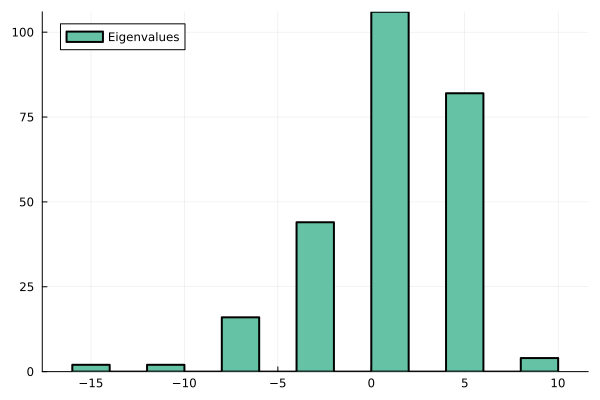

In [4]:
# G_test = create_random_signed_graph(6)

G_test = classify_state_frustration_number(6, 1)

# G_test = SignedGraph([[1], [2], [3], [4], [1, 2], [2, 3], [3, 4], [1, 4]], [0, 0, 0, 0, 1, 1, 1, 1])
# G_test = SignedGraph([[1], [2], [3], [4], [1, 2], [1, 3], [1, 4], [2, 4], [3, 4]], [0, 0, 0, 0, 1, 1, 1, 1, 1])
# G_test = SignedGraph([[1], [2], [3], [4], [1, 2], [1, 3], [2, 3], [2, 4], [3, 4]], [0, 0, 0, 0, -1, -1, -1, -1, -1])

# The following signed graph has 30 unbalanced cycles that can be balanced with 3 sign changes (frustration number = 3).
# The balanced version is the next signed graph.
# G_test = SignedGraph([[1], [2], [3], [4], [5], [6], [1, 2], [1, 5], [1, 6], [2, 3], [2, 4], [2, 5], [2, 6], [3, 4], [3, 5], [3, 6], [4, 6], [5, 6]], [0, 0, 0, 0, 0, 0, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
# G_test = SignedGraph([[1], [2], [3], [4], [5], [6], [1, 2], [1, 5], [1, 6], [2, 3], [2, 4], [2, 5], [2, 6], [3, 4], [3, 5], [3, 6], [4, 6], [5, 6]], [0, 0, 0, 0, 0, 0, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1])

println("Graph: ", G_test.l)
println("Signs: ", G_test.s)
println("$(length(find_cycles(G_test))) Cycles with signs $(evaluate_cycles_signs(G_test)): \n", find_cycles(G_test))
println("Number of unbalanced cycles: ", count_unbalanced_cycles(G_test))
println("Frustration number and sign change vector: ", find_frustration_number(G_test))
println("--------------------")
println("Number of negative eigenvalues: ", find_negative_eigs(G_test))
println("Degeneracy of the ground state: ", find_degeneracy_gs(G_test))
eigs_test = eigvals(create_hamiltonian_matrix(create_interaction_matrix(create_line_graph(G_test))))
println("Spectrum: ", eigs_test)
Plots.plot()
Plots.histogram!(eigs_test, bins=20, label="Eigenvalues")

#### Tests

In [ ]:
# using BenchmarkTools

G_test = create_random_signed_graph(6)

H_test = create_hamiltonian_matrix(create_interaction_matrix(create_line_graph(G_test)))

# _M = create_interaction_matrix(create_line_graph(G_test))
# @code_warntype create_hamiltonian_matrix(_M)

find_degeneracy_gs(G_test)

6

In [3]:
# println(Graph([[1], [2], [4], [1, 2], [3, 2], [2, 4], [3, 4], [2], [3]]).l == [[1], [2], [3], [4], [1, 2], [2, 3], [2, 4], [3, 4]])

# G = Graph([[1], [2], [4], [1, 2], [3, 2], [2, 4], [3, 4], [2], [3]])
# println(G.l)
# println(build_line_graph(G))

Gs = SignedGraph([[1], [2], [3], [4], [1, 2], [2, 3], [2, 4], [3, 4]], [0, 0, 0, 0, 1, -1, 1, 1])
println(string(Gs.l) * ", " * string(Gs.s))
println(create_line_graph(Gs))

# display(build_interaction_matrix(build_line_graph(Gs)))

# create_hamiltonian_matrix(build_interaction_matrix(build_line_graph(Gs)))

# testt = create_hamiltonian_matrix(build_interaction_matrix(build_line_graph(SignedGraph([[1], [2], [3], [4], [1, 4], [2, 3], [2, 4], [3, 4]], [0, 0, 0, 0, 1, 1, 1, -1]))))

# ρ_gibbs_ising(1, testt)

# purify(DensityMatrix(ρ_gibbs_ising(1, testt)))

# find_degeneracy_gs(3, create_hamiltonian_matrix(build_interaction_matrix(build_line_graph(Gs))))

# Example graphs from the notes
Gs1 = (SignedGraph([[1], [2], [3], [4], [1, 4], [2, 3], [2, 4], [3, 4]], [0, 0, 0, 0, 1, 1, 1, -1])) # Ising 1
Gs2 = (SignedGraph([[1], [2], [3], [4], [1, 2], [1, 4], [2, 3], [3, 4]], [0, 0, 0, 0, 1, -1, -1, 1])) # Ising 2
# find_degeneracy_gs(5, create_hamiltonian_matrix(build_interaction_matrix(build_line_graph(Gs))))


display(create_interaction_matrix(create_line_graph(Gs)))


println(eigvals(create_hamiltonian_matrix(create_interaction_matrix(create_line_graph(Gs2)))))
count(x->x<0, eigvals(create_hamiltonian_matrix(create_interaction_matrix(create_line_graph(Gs2)))))

[[1], [2], [3], [4], [1, 2], [2, 3], [2, 4], [3, 4]], [0, 0, 0, 0, 1, -1, 1, 1]
SignedGraph{Vector{Vector{Int64}}, Vector{Int64}}([[1], [2], [3], [4], [1, 2], [1, 3], [2, 3], [2, 4], [3, 4]], [0, 0, 0, 0, -1, 1, -1, -1, 1])
[-4.0, -4.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 4.0, 4.0]


4×4 Matrix{Int64}:
  0  -1   1   0
 -1   0  -1  -1
  1  -1   0   1
  0  -1   1   0

2

In [24]:
n = 4

# G_test = SignedGraph([[1], [2], [3], [4], [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]], [0, 0, 0, 0, -1, -1, -1, -1, -1, -1])
# G_test = SignedGraph([[1], [2], [3], [4], [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]], [0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
G_test = create_random_signed_graph(n)
while count(x->length(x)==2, G_test.l) < 2
    G_test = create_random_signed_graph(n)
end

println("Number of negative eigenvalues: ", find_negative_eigs(G_test))
println("Degeneracy of the ground state: ", find_degeneracy_gs(G_test))
println("Spectrum: ", eigvals(create_hamiltonian_matrix(create_interaction_matrix(create_line_graph(G_test)))))
Plots.plot()
Plots.histogram!(eigvals(create_hamiltonian_matrix(create_interaction_matrix(create_line_graph(G_test)))), bins=20, label="Eigenvalues")

#### Graph learning datasets

In [34]:
seed = 1234 # set seed for reproducibility
Random.seed!(seed)
 
n_graph = 4 # number of vertices
n = nextpow(2, binomial(binomial(n_graph, 2), 2)) # smallest power of 2 that is larger than the number of possible edges in the line graph
# n = 16 # preferably a power of 2
n_samples = 10
τ0 = 1.

graphs1 = []
states1 = ArrayReg{}[]
while length(states1) < n_samples*2
    try
        # push!(states1, create_purified_state(τ0, classify_state_negative_spectrum(n_graph, 1)))
        # push!(states1, create_purified_state(τ0, classify_state_degeneracy(n_graph, 1)))
        ####
        tmp_graph = classify_state_frustration_number(n_graph, 1)
        if all([tmp_graph != ele for ele in graphs1])
            push!(states1, create_purified_state(τ0, tmp_graph))
        end
    catch
        continue
    end
end

graphs2 = []
states2 = ArrayReg{}[]
while length(states2) < n_samples*2
    try
        # push!(states2, create_purified_state(τ0, classify_state_negative_spectrum(n_graph, -1)))
        # push!(states2, create_purified_state(τ0, classify_state_degeneracy(n_graph, -1)))
        ####
        tmp_graph = classify_state_frustration_number(n_graph, -1)
        if all([tmp_graph != ele for ele in graphs2])
            push!(states2, create_purified_state(τ0, tmp_graph))
        end
    catch
        continue
    end
end

if maximum([nactive(states1[i]) for i in 1:length(states1)]) > n || maximum([nactive(states2[i]) for i in 1:length(states2)]) > n
    error("Not enough qubits in the model, increase n.")
end

for i in 1:n_samples*2
    append_qubits!(states1[i], n - nactive(states1[i]))
    append_qubits!(states2[i], n - nactive(states2[i]))
end
 
# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)
 
# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)
 
# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

#### Examples: run one cell

In [55]:
### Example: random vs uniform states ###

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 20
states1 = [rand_state(n) for i=1:n_samples*2]
states2 = [uniform_state(n) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

In [5]:
### Example: high- vs low- entanglement states ###

function classify_state(n, label; threshold=0.6, max_iter=1000)
    state = rand_state(n)
    iter = 0
    if label == 1
        while von_neumann_entropy(state, 1) < threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    else
        while von_neumann_entropy(state, 1) > threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    end
    iter == max_iter ? error("Could not generate state") :
    return state
end

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 10
states1 = [classify_state(n, 1) for i=1:n_samples*2]
states2 = [classify_state(n, -1) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

#### Model parameters

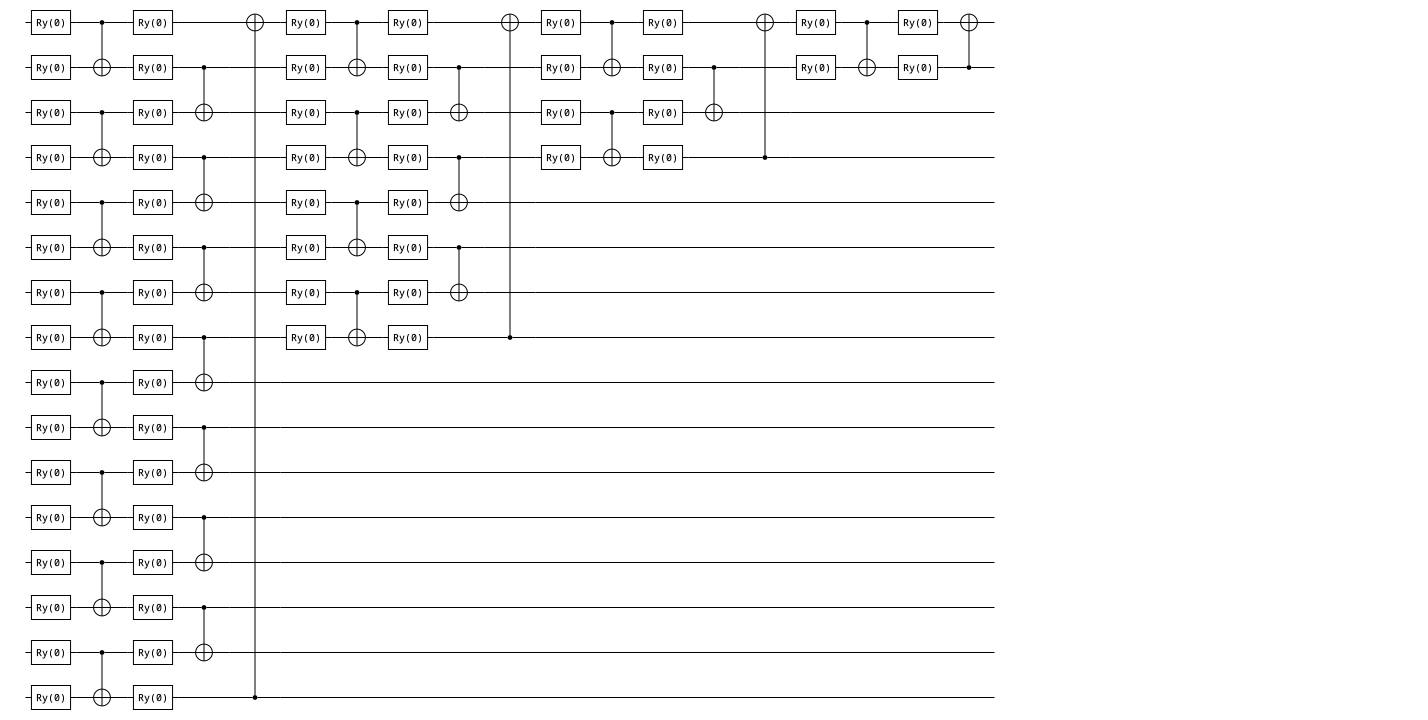

In [37]:
iters = 10 # number of iterations
lr = 0.1 # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.
sig = true # use the sigmoid activation function
ansatz = conv_Ry # conv_Ry, conv_Ry2, conv_SU4

circ = build_QCNN(n, ansatz=ansatz)

# p = GenericParams(n=n, circ=circ)
p = InvariantParams(n=n, circ=circ, ansatz=ansatz)
initialize_params(p);

YaoPlots.plot(circ)

#### Run

In [38]:
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(d1, d2, p, iters, optim, sig; output=true)

Initial: loss = 1.2652515705151732,tr_acc = 0.4, te_acc = 0.5


InterruptException: InterruptException:

#### Plot

In [9]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1)

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2)

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))

UndefVarError: UndefVarError: `loss_track` not defined